APPLE STOCK PRICE FORECASTING PROJECT

**Objective:**
This project's business problem revolves around forecasting Apple Inc.'s stock prices using historical data. Forecasting aims to provide actionable insights for potential investment decisions, identify optimal buying and selling points, and understand market trends to mitigate risks associated with volatility.

In today's highly volatile financial markets, timely and accurate forecasting of stock prices is crucial for investors and companies to make informed decisions. With the rapid changes in economic conditions and market sentiment, having a predictive outlook on stock prices helps in capitalizing on market opportunities and avoiding potential losses. This project addresses this need by applying sophisticated forecasting techniques to derive insights from historical price movements.


Importing all the necessary libraries to develop this project.

In [ ]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import matplotlib
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa import tsatools
import statsmodels.formula.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.formula.api import ols
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing the Apple Stock Data Set.

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/Colab BUSA 720/Data/AAPL (1).csv")
price = df.loc[df['Close'] == 'price']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       756 non-null    object 
 1   Open       756 non-null    float64
 2   High       756 non-null    float64
 3   Low        756 non-null    float64
 4   Close      756 non-null    float64
 5   Adj Close  756 non-null    float64
 6   Volume     756 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 41.5+ KB


The Apple Stock Price data set contains 7 columns, 6 of them are numerical and only 1 is categorical.

Above are the first 5 rows of the data set; Based on this we can have an idea of how our data looks like.

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-03-01,123.750000,127.930000,122.790001,127.790001,125.599655,116307900
1,2021-03-02,128.410004,128.720001,125.010002,125.120003,122.975410,102260900
2,2021-03-03,124.809998,125.709999,121.839996,122.059998,119.967850,112966300
3,2021-03-04,121.750000,123.599998,118.620003,120.129997,118.070938,178155000
4,2021-03-05,120.980003,121.940002,117.570000,121.419998,119.338829,153766600


In [ ]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,756.000000,756.000000,756.000000,756.000000,756.000000,7.560000e+02
mean,158.746548,160.469749,157.182420,158.916786,157.599558,7.666230e+07
std,20.149521,20.090118,20.164522,20.143191,20.550971,2.694314e+07
min,119.029999,120.400002,116.209999,116.360001,114.365555,2.404830e+07
25%,144.014999,146.404995,142.649994,144.552505,142.949295,5.637490e+07
50%,156.845001,158.705001,154.400001,156.854996,155.408600,7.126770e+07
75%,174.950005,176.674995,173.494995,175.080002,173.663792,9.037062e+07
max,198.020004,199.619995,197.000000,198.110001,197.857529,1.954327e+08


We have a 3 years of Apple stock prices data, which is enough to analyze and forecast Apple stock prices.

Since our project will be focused on the stock's closing price, the preceding chart offers valuable insights. It reveals that the average closing price over the available years in our dataset stands at 158.92, accompanied by a notable standard deviation of 20.14. This standard deviation appears significant when considering the minimum and maximum stock closing prices, suggesting the potential for volatility in the Apple stock market.








Below we can see the minimum and maximum apple stock price in our data set and their dates. This can allow us to identify the seasons of the year where the stock prices increase or decrease. Therefore we will be able to identify the best time for traders to buy or sell Apple stocks and the possible closing price.

In [ ]:
min_close_index = df['Close'].idxmin()

# Get the corresponding date from the "Date" column
min_close_date = df.loc[min_close_index, 'Date']
print("Minimum value of 'Stock Close Price' column:", df['Close'].min())
print("Date corresponding to the minimum value:", min_close_date)

Minimum value of 'Stock Close Price' column: 116.360001
Date corresponding to the minimum value: 2021-03-08


In [ ]:
max_close_index = df['Close'].idxmax()

# Get the corresponding date from the "Date" column
max_close_date = df.loc[max_close_index, 'Date']
print("Minimum value of 'Stock Close Price' column:", df['Close'].max())
print("Date corresponding to the maximum value:", max_close_date)

Minimum value of 'Stock Close Price' column: 198.110001
Date corresponding to the maximum value: 2023-12-14


Data Preprocessing:
This step includes removing columns we do not need, check missing values,
aggregate prices by date and so on.

In [ ]:
cols = ['Date', 'Close']

In [ ]:
price= df[cols]
price = price.sort_values('Date')

In [ ]:
price

,Date,Close
0,2021-03-01,127.790001
1,2021-03-02,125.120003
2,2021-03-03,122.059998
3,2021-03-04,120.129997
4,2021-03-05,121.419998
...,...,...
751,2024-02-23,182.520004
752,2024-02-26,181.160004
753,2024-02-27,182.630005
754,2024-02-28,181.419998


Checking for missing values to have the most accurate possible forecast.

In [ ]:
price.isnull().sum()

Date     0
Close    0
dtype: int64

As we can see, there are no missing values in our data set.

In [ ]:
stock_prices = price.groupby('Date')['Close'].sum().reset_index()

print(stock_prices)

           Date       Close
0    2021-03-01  127.790001
1    2021-03-02  125.120003
2    2021-03-03  122.059998
3    2021-03-04  120.129997
4    2021-03-05  121.419998
..          ...         ...
751  2024-02-23  182.520004
752  2024-02-26  181.160004
753  2024-02-27  182.630005
754  2024-02-28  181.419998
755  2024-02-29  180.750000

[756 rows x 2 columns]


Indexing with Time Series Data

In [ ]:
price['Date'] = pd.to_datetime(price['Date'])
price.set_index('Date', inplace=True)



Since it can be difficult to work with our present datetime data, we will instead utilize the average monthly closing prices, with the timestamp being the beginning of each month.
Let's quickly examine the Apple Stock Price for 2023.

In [ ]:
y = price['Close'].resample('MS').mean()

In [ ]:
y['2023':]

Date
2023-01-01    135.778999
2023-02-01    150.968421
2023-03-01    154.964782
2023-04-01    165.045790
2023-05-01    172.622728
2023-06-01    184.283333
2023-07-01    192.411501
2023-08-01    181.083913
2023-09-01    177.002501
2023-10-01    174.668638
2023-11-01    185.879523
2023-12-01    194.308501
2024-01-01    187.724284
2024-02-01    184.775501
Freq: MS, Name: Close, dtype: float64

Plotting Apple Stock Close Price Time Series Data

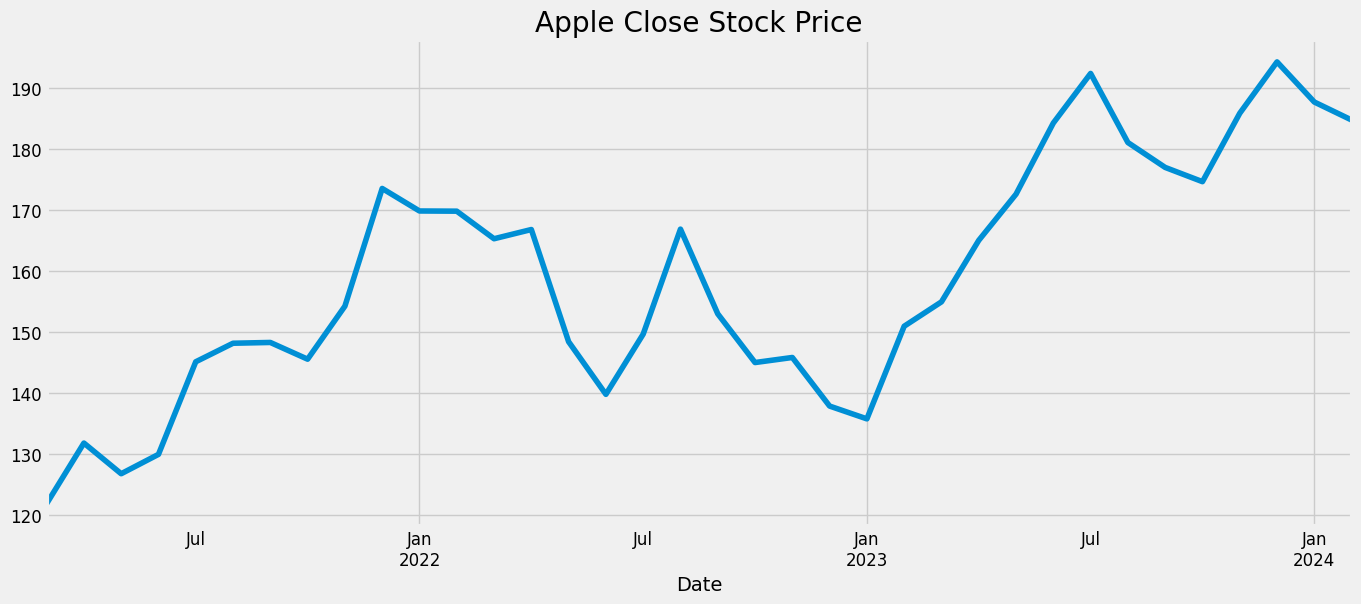

In [ ]:
y.plot(figsize=(15, 6))
plt.title('Apple Close Stock Price')
plt.show()

The data plot showcases some clear patterns, such as, the time-series
shows a seasonality pattern in the last two years, as stocks prices reach a peak around July and decrease in the following months. Additionally, there is a clear upward trend.
Another way we can display our data is by breaking down our time series into three separate components: trend, seasonality, and noise. This technique is known as time-series decomposition.

Comparing the Time Series of Opening prices vs. Closing prices

Checking the shape of the Open and Close Stock Prices Columns.

In [ ]:
price_open = df['Open']
price_close = df['Close']
price.shape, price.shape

((756, 1), (756, 1))

Data Exploration
We will compare Apple opening prices and closing prices during the same time frame. Therefore we will combine two data frames into one and create a single plot with the time series for these two types of price.

In [ ]:
cols_1 = ['Date', 'Open', 'Close']
price_1= df[cols_1]

# Convert 'Date' column to datetime
price_1['Date'] = pd.to_datetime(price_1['Date'])

price_open = price_1.sort_values('Date')
price_close = price_1.sort_values('Date')
price_open = price_1.groupby('Date')['Open'].sum().reset_index()
price_close = price_1.groupby('Date')['Close'].sum().reset_index()
price_open = price_open.set_index('Date')
price_close = price_close.set_index('Date')
y_open = price_open['Open'].resample('MS').mean()
y_close = price_close['Close'].resample('MS').mean()
price_open = pd.DataFrame({'Date':y_open.index, 'Open':y_open.values})
price_close = pd.DataFrame({'Date': y_close.index, 'Close': y_close.values})
general_prices = price_open.merge(price_close, how='inner', on='Date')
general_prices.rename(columns={'Prices_x': 'open_prices', 'Prices_y': 'close_prices'}, inplace=True)
general_prices.head()

,Date,Open,Close
0,2021-03-01,122.087392,121.871304
1,2021-04-01,131.672382,131.812858
2,2021-05-01,127.035001,126.784000
3,2021-06-01,129.489546,129.958636
4,2021-07-01,144.570478,145.139524


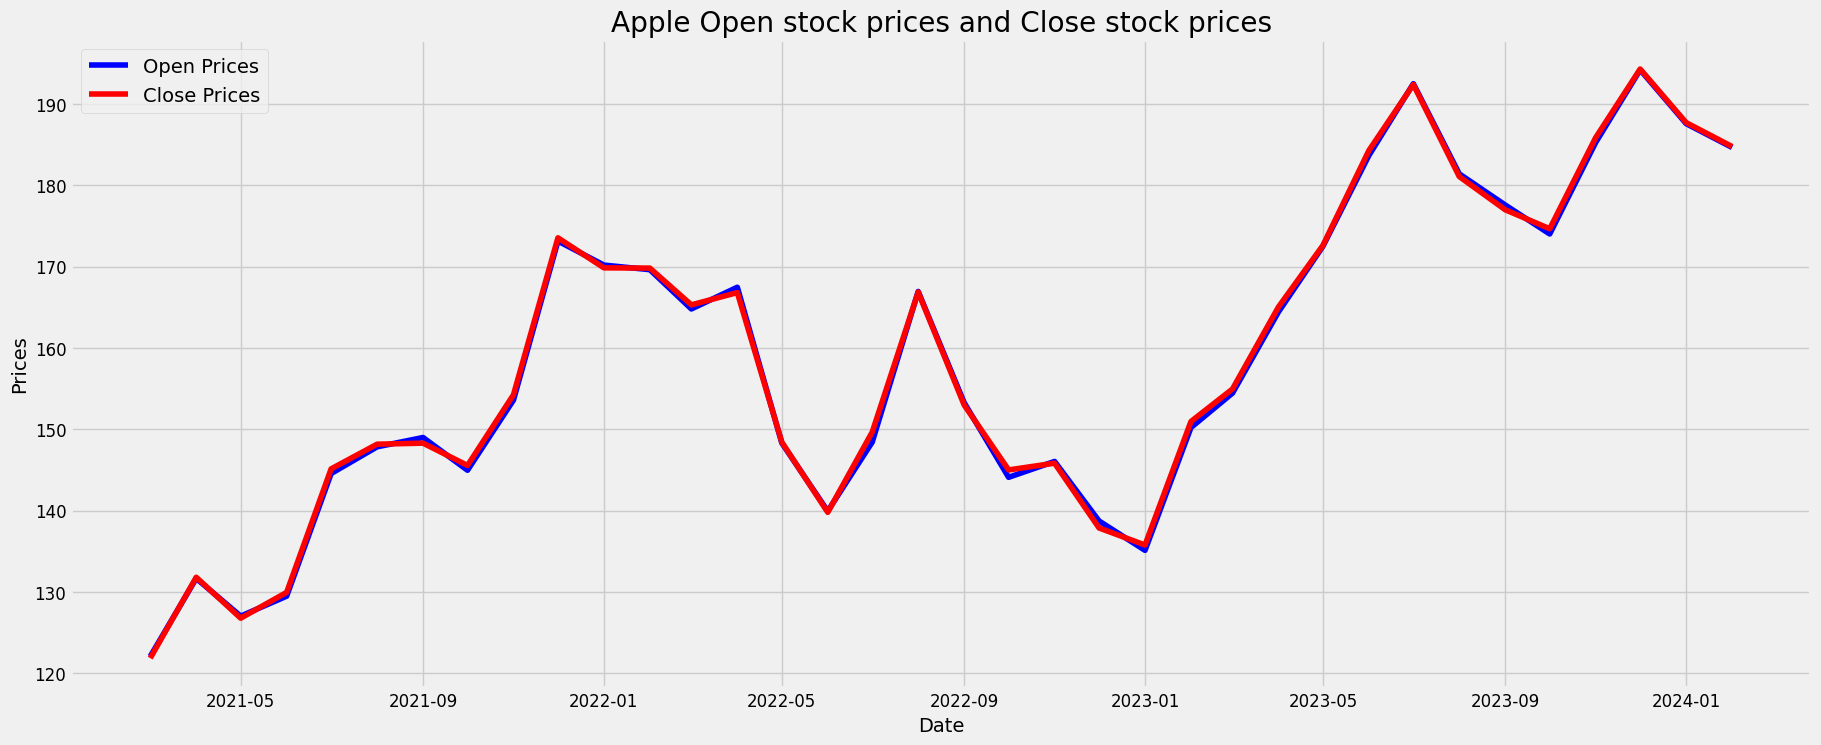

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(general_prices['Date'], general_prices['Open'], 'b-', label='Open Prices')
plt.plot(general_prices['Date'], general_prices['Close'], 'r-', label='Close Prices')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.title('Apple Open stock prices and Close stock prices')
plt.legend()

The plot above illustrates the average open stock price, representing the price at the start of the day, and the average close price, indicating the price at the end of the day. It's evident from the plot that there's minimal disproportion between the two, suggesting that fluctuations in the stock price throughout the day is insignificant.
We also observe that opening stock prices and closening stock prices shared a similar
seasonal pattern. It seems that around July prices are at their highest. It is understandable, as the stock prices don't fluctuate too much in one day.

Seasonal decomposition of Apple Stock Close Price data set, using an additive model.

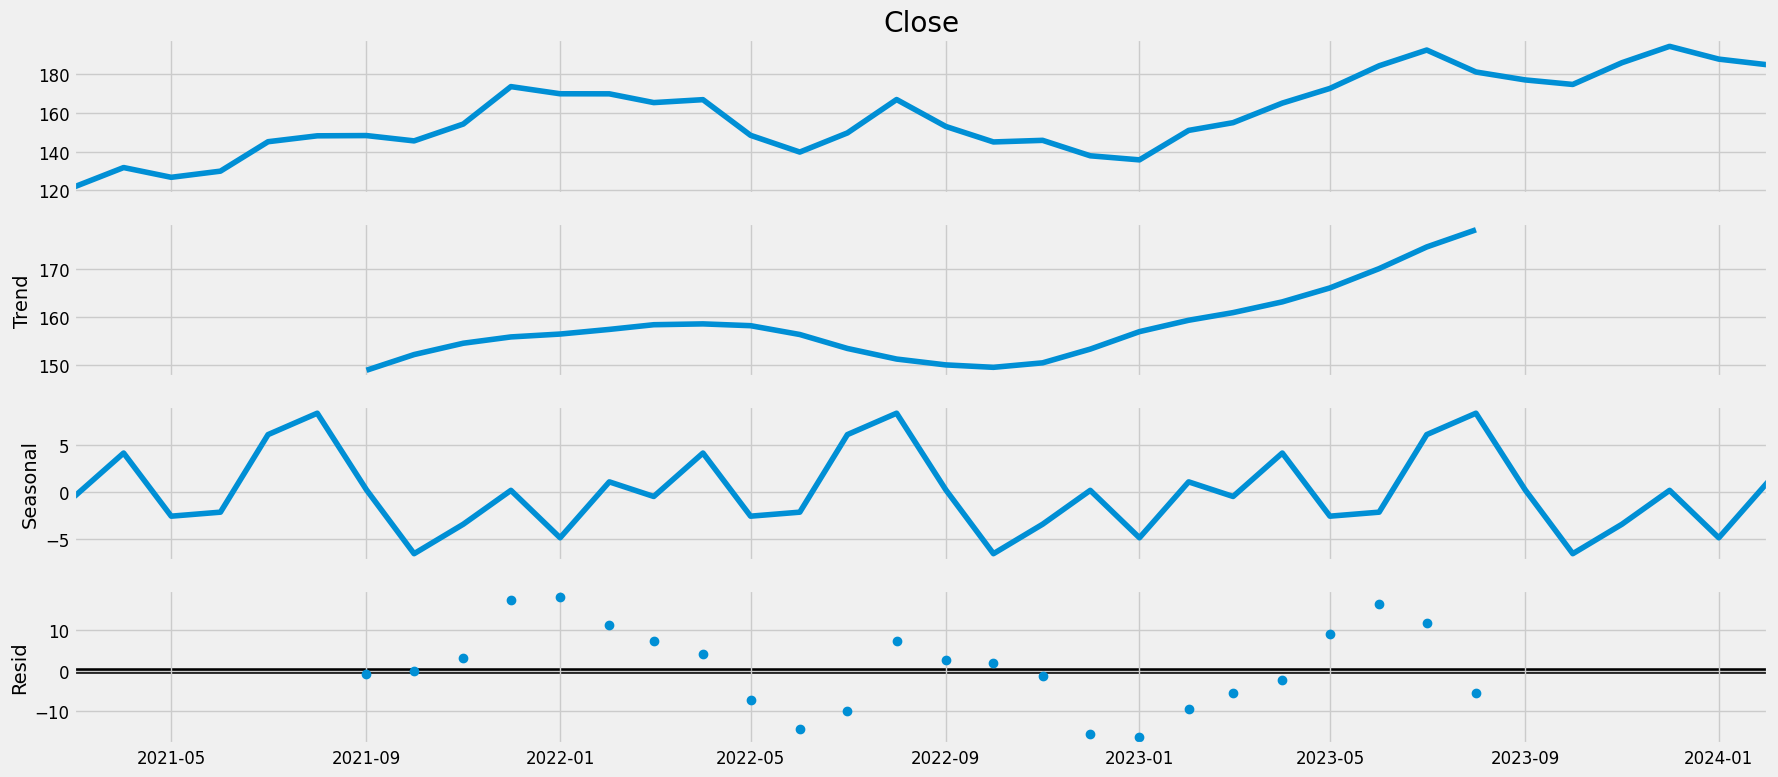

In [ ]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

The above visualization indicates evident seasonal patterns, an upward trend, and volatility in Apple's Closing Stock prices. This plot corroborates the earlier analysis regarding the volatility of the stock prices.







**Time series forecasting with ARIMA.**

We will implement Autoregressive Integrated Moving Average (ARIMA), a widely-used method for time-series forecasting that is represented by the notation ARIMA(p, d, q). These parameters, p, d, and q, capture the seasonality, trend, and noise present in the data. Arima models are based on the assumption that the underlying data is stationary, which means that the variables such as variance and mean are constant overtime. This assumption enables ARIMA models to effectively capture and represent the temporal relationships inherent in the data.

ARIMA (AutoRegressive Integrated Moving Average) and SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors) are both time series forecasting models, but SARIMAX is an extension of ARIMA that adds the capability to model seasonal effects and incorporate exogenous variables, making it more flexible for a wider range of time series forecasting tasks.















In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


The ARIMA Time Series Model for Apple stock prices is being selected in this step. Here, we want to employ a "grid search" technique to identify the optimal set of parameters that will provide the best results for our model.

p is the order of the autoregressive (AR) component, d is the degree of differencing, q is the order of the moving average (MA) component, P is the seasonal order of the autoregressive (SAR) component, D is the seasonal degree of differencing, Q is the seasonal order of the moving average (SMA) component.

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,order=param,seasonal_order=param_seasonal,
            enforce_stationarity=False,
            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:457.10895985181384
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:292.68617797981744
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:222.74052818794013
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:112.74639275045368
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:229.2046915519946
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:212.1041899252914
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:121.68005449616889
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:114.70258520617271
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:404.22808145730784
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:255.38260497178405
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:192.77245953612902
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:95.0301511096047
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:210.15645302150858


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:195.41293528505884
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:111.03576470925564
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:95.37023417571473
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:249.7191968363013
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:165.83737387507915
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:182.51174807511345
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:80.6564406161821
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:173.3315984324548
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:165.43331943483312
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:79.81325420777313
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:75.86983670665494
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:242.8054275602824
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:155.24933352801276
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:173.84246672507007
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:70.70481160965505
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:173.524211102841
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:154.92553153096796
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:79.7317570499065
ARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:175.18612547552237
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:173.81111818008577
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:80.6954623943261
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:82.68210491650422
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:251.12698013871625
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:167.0728247458275
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:180.87742018983445
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:82.18090745538827
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:175.4466988762151
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:166.24744167949893
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:80.7942582959731
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:76.8080101067667
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:250.68698134671115
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:167.44415069145228
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:182.52096878643934
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:81.43912820781541
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:168.24063302312084
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:166.35855872233842
ARI


According to our output the optimal set of parameters that will provide the best results for our model is SARIMAX(0, 1, 1)x(1, 1, 1, 12) as it generates the
lowest AIC value of 66.77. Therefore we should consider this to be optimal
option.

The AIC (Akaike Information Criterion) is a measure of the relative quality of a statistical model for a given set of data. It balances the trade-off between the goodness of fit of the model and the complexity of the model. The AIC is defined as: -2 * log(likehood) + 2 * number of parameters.

The AIC penalizes models for having more parameters, thus favoring simpler models that explain the data well without being overly complex. Therefore, when comparing different models fitted to the same data, the model with the lowest AIC is generally preferred because it strikes the best balance between goodness of fit and model complexity.

**Fitting the SARIMAX model**

In [ ]:
mod = sm.tsa.statespace.SARIMAX(y,
order=(0, 1, 1),
seasonal_order=(1, 1, 1, 12),
enforce_stationarity=False,
enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4648      1.046      0.444      0.657      -1.585       2.515
ar.S.L12      -0.9598      0.311     -3.083      0.002      -1.570      -0.350
ma.S.L12       0.6760    2.4e+04   2.82e-05      1.000   -4.71e+04    4.71e+04
sigma2        27.5267   6.13e+05   4.49e-05      1.000    -1.2e+06     1.2e+06


Moving Average Terms (ma.L1 and ma.S.L12): Neither coefficient is statistically significant (P> 0.05), indicating that the moving average terms may not be reliable predictors of Apple's stock prices in this model.

Autoregressive Effect (ar.S.L12): Significant negative autoregressive effect with a seasonal lag of 12 months.

Variance of Error Term (sigma2): Unexplained variability in Apple's stock prices that is not accounted for by the model's predictors

The model captures a significant autoregressive effect with a seasonal lag of 12 months in Apple's stock prices. However, the moving average terms do not appear to be significant predictors in this model.



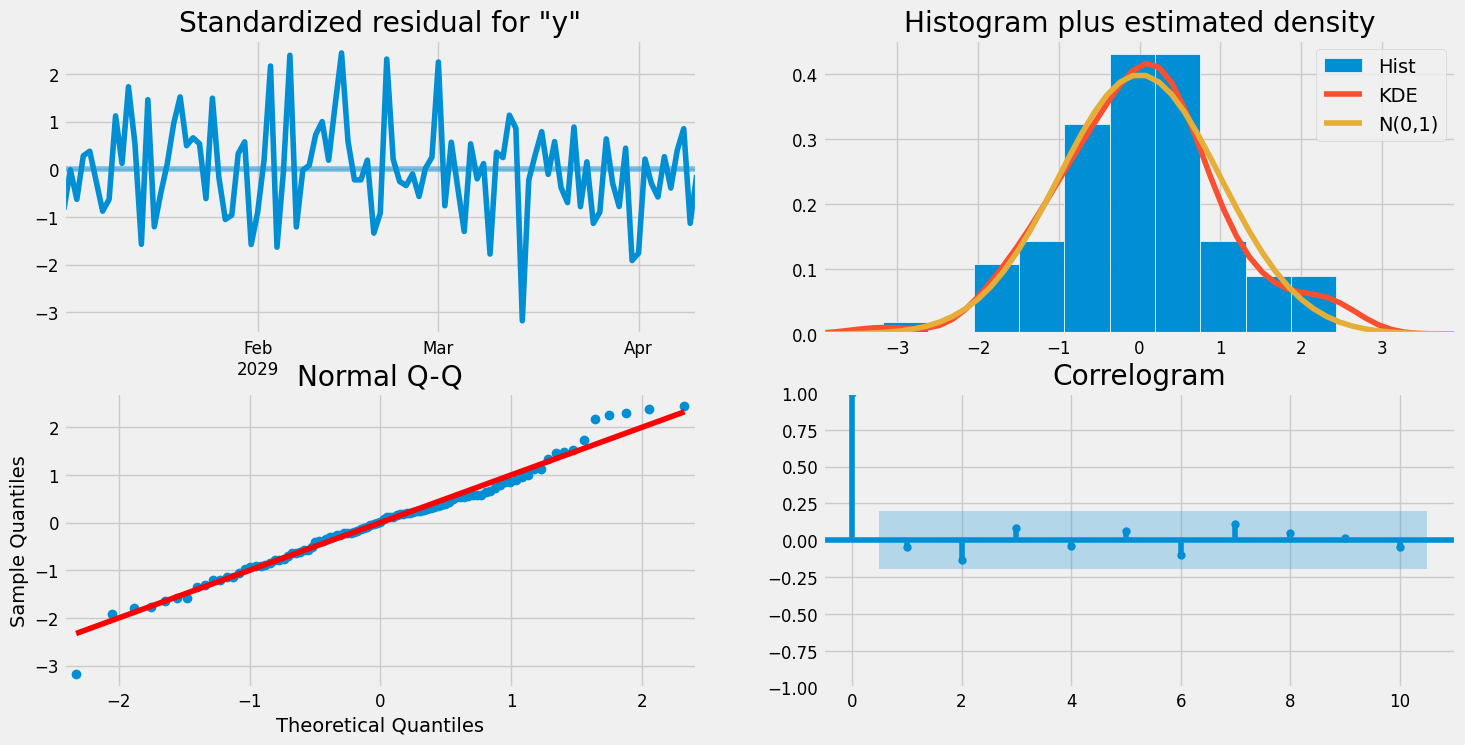

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Assuming 'endog' and 'exog' are defined
# Let's create some sample data for demonstration

# Sample endogenous variable (target)
endog = pd.Series(np.random.randn(100), index=pd.date_range('2029-01-01', periods=100))

# Sample exogenous variables
exog = pd.DataFrame({
    'exog_var1': np.random.rand(100),
    'exog_var2': np.random.rand(100)
}, index=pd.date_range('2029-01-01', periods=100))

# Model parameters (replace with appropriate values)
p = 0  # Autoregressive order
d = 1  # Differencing order
q = 1  # Moving average order

# Fit the time series model
model = sm.tsa.ARIMA(endog, order=(p, d, q), exog=exog).fit()

# Plot diagnostics
fig = model.plot_diagnostics(figsize=(16, 8))
plt.show()

Our model diagnostics suggest that the model
residuals are near normally distributed.

Standardized residuals for Y: Standardized residuals are residuals that have been divided by an estimate of their standard deviation. Therefore, they measure of how far each individual observation in a time series deviates from the expected value predicted by the model, relative to the variability of the data. The model seems to fit overall as there are only a few high spikes.

Normal Q-Q: Assess whether a set of data follows a normal distribution. If the data perfectly follows a normal distribution, the points on the plot will fall along the straight line, which is very close to our case.

Correlogram: Allows to assess autocorrelation which measures the correlation between a time series and a lagged version of itself at different time lags. The autocorrelation coefficient at lag 0 is always 1 because it represents the correlation of the series with itself. Autocorrelation coefficients near 0 indicate little to no linear relationship between the series and its lagged values. Therefore, the presence of autocorrelation in the residuals can indicate that the model has captured most of the temporal dependencies in the data, which is not our case.

Histogram: Allows to visualize the distribution of a dataset and estimate its probability density function. It helps to identify the central tendency and spread of the residuals. Additionally, we can detect skewness, heavy tails, and if a normal distribution is followed. Our model diagnostics suggest that the model residuals are near normally distributed.

**One Step Ahead Forecast Method.**

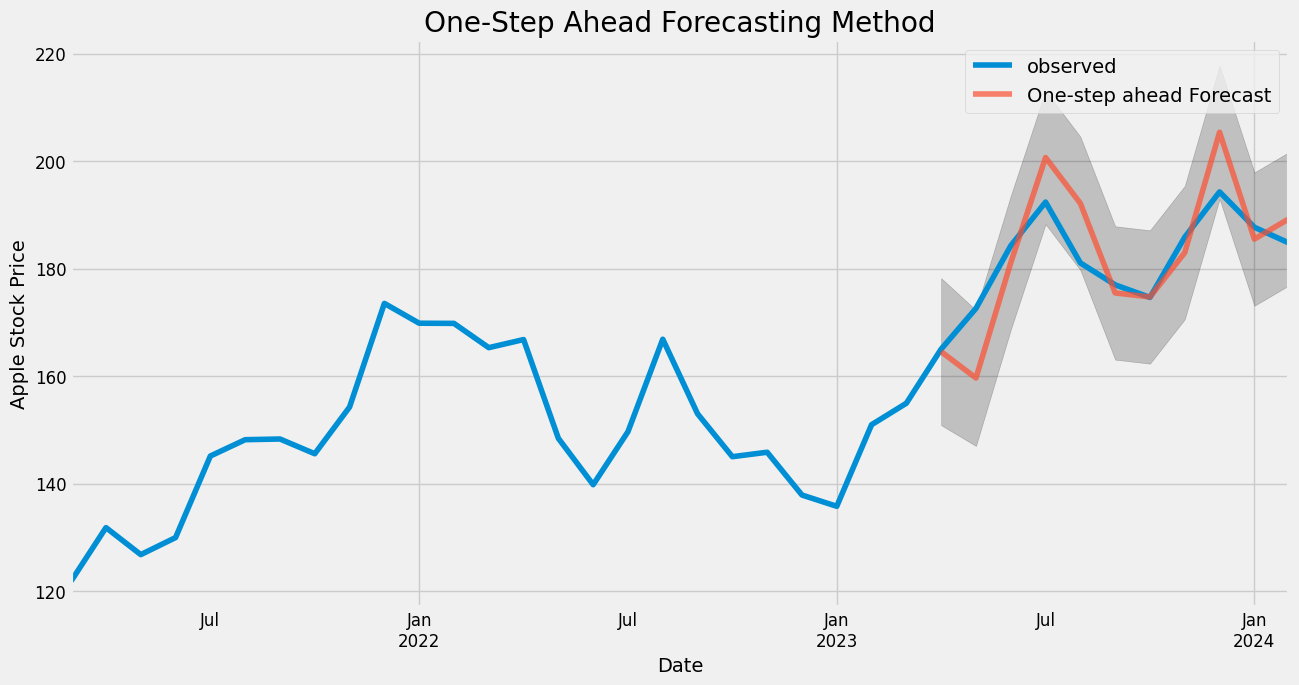

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2023-04-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2021':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Apple Stock Price')

# Adding title
ax.set_title('One-Step Ahead Forecasting Method')

plt.legend()
plt.show()


This forecasting technique provides predictions spanning from April 1, 2023, to around March 2024. The plot illustrates the comparison between observed values represented by the blue line and the rolling forecast predictions indicated by the red line. Generally, our forecasts closely match the actual values, exhibiting an upward trend from the start of the year and accurately capturing the seasonal patterns towards the year's end.

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = y['2023-04-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 48.13



Our forecasts have a Mean Squared Error of 48.13. The average of the squares of the errors, or the average squared difference between the estimated values and what is estimated, is measured by the mean squared error (MSE) of an estimator in statistics. An estimator's quality is gauged by its mean square error (MSE), which should always be non-negative and small, indicating a proximity to the line of best fit.

In [ ]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 6.94


The Root Mean Squared Error (RMSE) is used to evaluate the performance of a forecasting model. It's the square root of the Mean Squared Error (MSE) and is expressed in the same units as the original data, making it easier to interpret in the context of the problem.

A RMSE of 6.94 indicates that, on average, the difference between the forecasted values and the actual values is approximately 6.94 units. Since our data ranges from 116 to 198, an RMSE of 6.94 suggests that the average error, in terms of the original units of your data, is relatively small compared to the overall range. Our model is fairly accurate.

Forecasting For Future Time Steps.


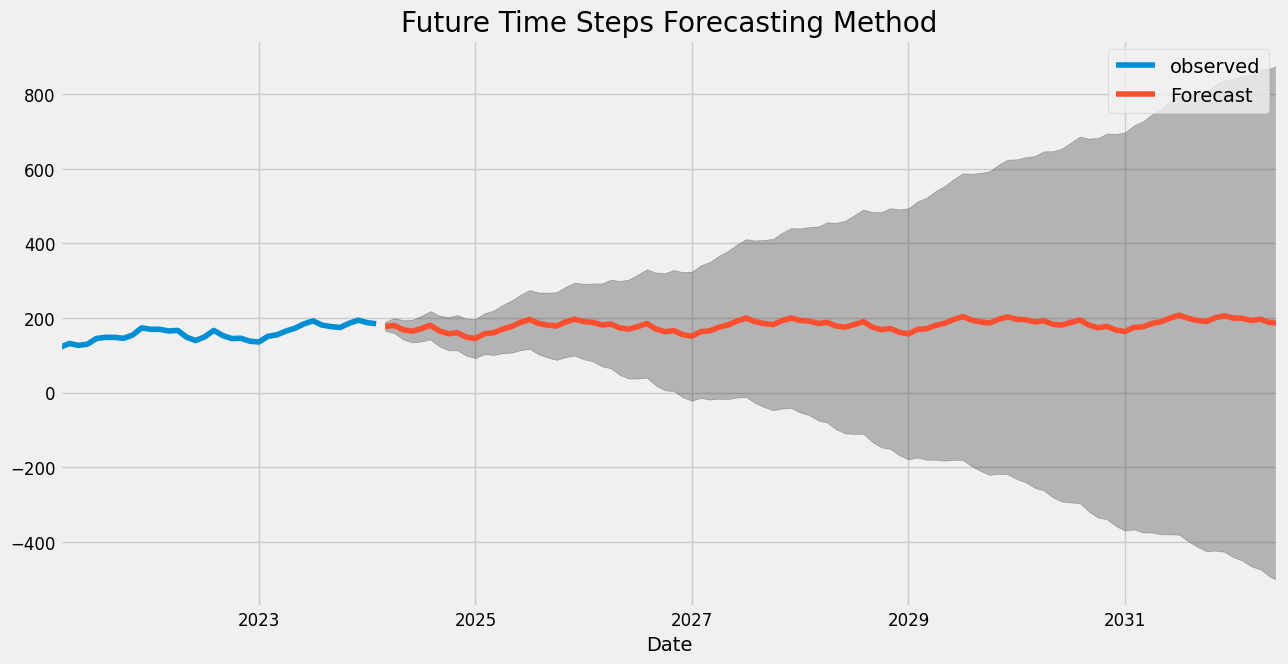

In [ ]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

# Adding title
ax.set_title('Future Time Steps Forecasting Method')

# Displaying the plot
plt.legend()
plt.show()

Our model effectively captured the seasonal patterns in closing stock prices. However, as we extend our forecasts into the future, it's natural for our confidence in those predictions to diminish. This decrease in confidence is evident in the widening of the confidence intervals produced by our model as we project further ahead.

Resetting the index for the data frame and grouping the data daframe by the columns Date and Close and creating a times series.

In [ ]:
# Reset index to make 'Date' a regular column
price.reset_index(inplace=True)
# Group by 'Date' and sum 'Close'
price_ts = price.groupby('Date')['Close'].sum()

# Recreate DataFrame with 'Date' as index
price_ts = pd.DataFrame({'Close': price_ts})


In [ ]:
price.set_index('Date', inplace=True)

In [ ]:
Price = price['Close'].resample('MS').mean()


Holt's Winter Forecasting Mehod.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


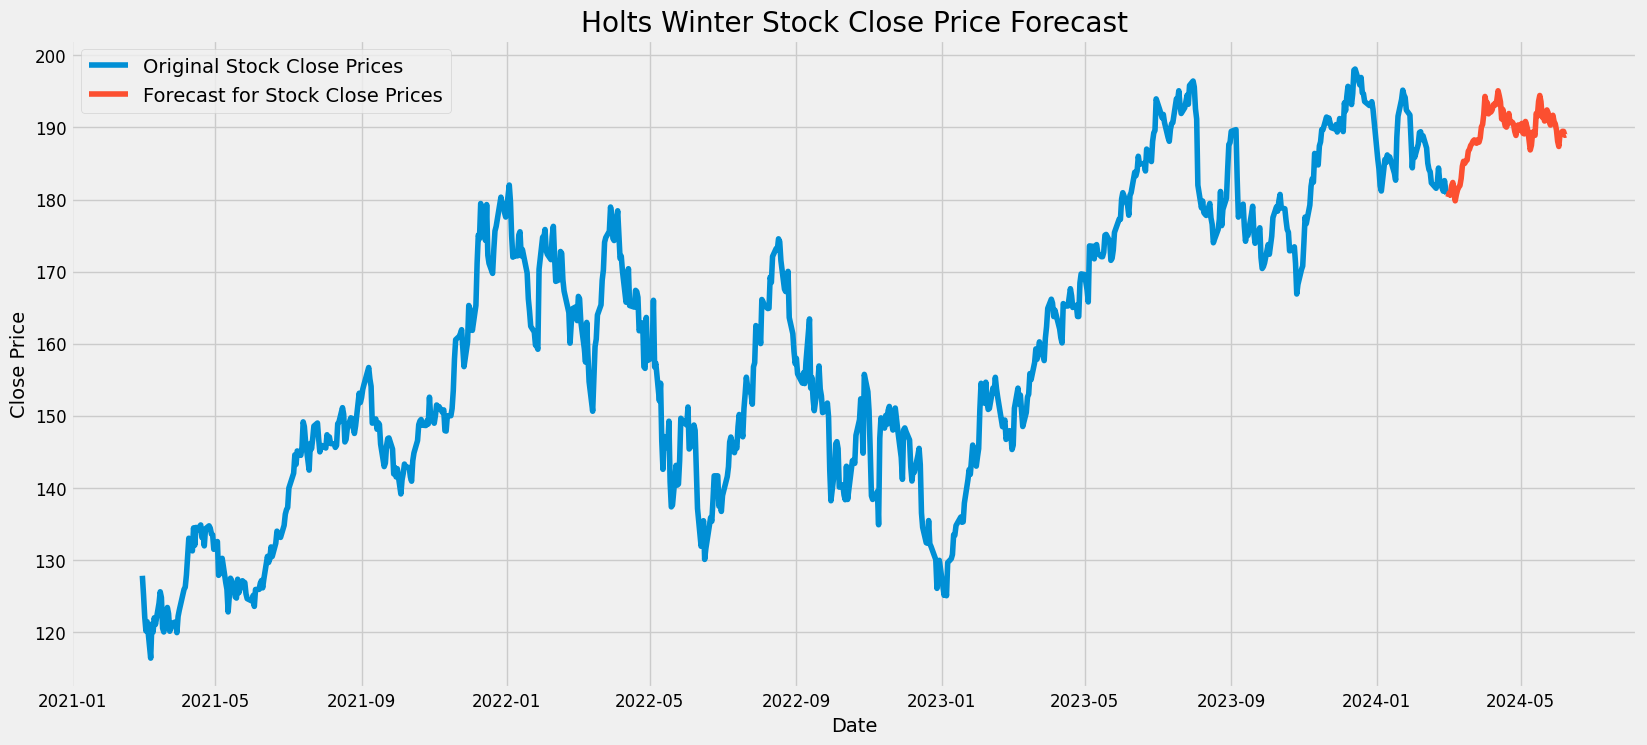

In [ ]:
# Filter price data for years between 2021 and 2024
price_filtered = price_ts['2021':'2024']

# Fit exponential smoothing model
model = ExponentialSmoothing(price_filtered, trend='add', seasonal='add', seasonal_periods=100)
fit = model.fit()

# Make predictions for 100 days after the last data point
last_date = price_filtered.index[-1]
forecast_index = pd.date_range(start=last_date, periods=101)[1:]
predictions = fit.forecast(100)

# Plot the original close prices and forecasted prices
plt.plot(price_filtered.index, price_filtered, label='Original Stock Close Prices')
plt.plot(forecast_index, predictions, label='Forecast for Stock Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Holts Winter Stock Close Price Forecast')
plt.legend()
plt.show()

This plot illustrates Holt's Winter Exponential Smoothing method; This method includes seasonality and trend as parameters to create a forecast; As we can see the forecast for the next 100 days captures the trend and the seasonality of our data set; This method creates a good forecast based on the available data. Comparing the forecasted stock prices for the months from January to May with the stock prices of the corresponding dates in previous years, it becomes evident that the trend is being accurately captured. Historical data shows an uptrend during these months in previous years, and the forecast predicts a similar upward trend.
Regarding seasonality, the data demonstrates a notable level of fluctuation in previous years, which is also reflected in the forecasted values. This suggests that the model has effectively captured the seasonality present in the data.

**Results:**






The analysis revealed that examining Apple's stock prices over three years highlighted a significant upward trend diversification with identifiable seasonal patterns consistent with the overall findings. The data cleanliness was confirmed, and no missing values were detected, thus ensuring the robustness of subsequent analyses.

**Moving Average with SARIMAX Forecasting Method:**

The moving average created with the parameters obtained from the SARIMAX model creates a forecast that captures the trend and seasonality; However, the metrics are not good, which implies that there could be problems with estimating the parameters accurately; Therefore this is not the best method to generate forecast.


**One-Step Ahead Forecasting:**

The forecast period predictions were made one step ahead, from April 2023 to March 2024. This short-term forecast aligns with the model's strength in capturing immediate trends and seasonal effects. Forecast accuracy was assessed using mean square error (MSE) and root mean square error (RMSE); Given that the lowest close stock price is 116 and the highest is 198, these values indicate that the forecast accuracy is remarkably high, as they are relatively low in comparison.

**Forecasting for Future Time Steps:**

Since the forecasting for future time steps is a variation of the one step ahead forecasting method, it's obvious that this method captures seasonality and trends but this method in particular can be used to forecast for longer periods than the one-step-ahead method.

**Holt's Winter Forecasting Method:**

The Holt-Winters Exponential Smoothing technique was employed to predict the subsequent 100 days beyond the latest available data point. This approach yields outstanding forecasts for the close stock price over the medium term, effectively capturing both the trends and seasonality within this 3 years.


**Conclusion:**

**Moving Average with SARIMAX Forecasting Method:**

This method was used for this analysis because it integrates seasonality, trends, and external variables into the forecasting model, making it adaptable to various types of time series data. However, while the method was expected to perform well due to its comprehensive modeling capabilities, the results indicated poor metrics, suggesting issues with parameter estimation or model specification.


**One-Step Ahead Forecasting:**

This method was chosen for this analysis because it provides predictions from a known last point, April 2023, by repeatedly predicting one step into the future up to March 2024. This method is able to handle autocorrelation and seasonal patterns effectively. This method aligned well with actual historical values, indicating high accuracy as evidenced by low MSE and RMSE values, making it suitable for short-term forecasting.


**Forecasting for Future Time Steps:**

This method was chosen because it extends the one-step ahead approach by forecasting multiple future points based on the model's initial setup. It is intended to provide a more extended outlook while still handling complex patterns. The increasing uncertainty in forecast confidence intervals over time suggests a natural limit to forecasting accuracy as predictions extend further into the future.


**Holt's Winter Forecasting Method:**

This method focuses on capturing seasonal fluctuations and trends using exponential smoothing, which is effective for data with seasonal solid patterns. It produced good forecasts for up to 100 days beyond the available data, effectively utilizing the data's trend and seasonal characteristics. This method proved reliable for medium-term forecasting.

The most appropriate forecasting techniques for the specific needs of forecasting Apple's stock prices, which exhibit both an overall upward trend and seasonal fluctuations, are the One-Step Ahead Forecasting, Forecasting for Future Time Steps, and Holt's Winter Forecasting Method. The One-Step Ahead method is suited for short-term forecasts, as it aligned well with actual historical values, indicating high accuracy as evidenced by low MSE and RMSE values. The Future Time Steps forecasting method is suited for long-term forecasts, as it provided a more extended outlook while still handling complex patterns. Both the one-step-ahead and future time steps forecasting methods are related, focusing on immediate next steps and extended future predictions. The Holt-Winter method is recommended for medium-term forecasts because it effectively utilizes the data's trend and seasonal characteristics and its strength in handling seasonal variations, distinct from the more complex SARIMAX approach.

**Recommendations:**

**Optimal Buying and Selling Periods**

Given our analysis, we recommend buying during an uptrend; specifically, our analysis suggests purchasing from April through July. This period historically shows an upward momentum in stock prices, presenting a potential for further price appreciation to capitalize on the momentum and potential for additional price appreciation. Based on our analysis, the optimal months for selling during a downtrend, to minimize losses and preserve capital, are from August to October. This strategy is based on historical data indicating a general decline in stock prices during these months. This will help diminish losses and preserve capital.

**Analyze Earning Reports**

Analyzing closely Apple's quarterly earnings reports. Analyze not just the earnings per share and revenue numbers but also the guidance provided by the company for future quarters. These insights can give you a sense of the company's trajectory. Listening to the earnings call, especially the Q&A session, where analysts often probe for information not contained in the report. By paying attention to any changes specifically in the tone of the executives, this might indicate a shift in the company's outlook.

**Monitor Market Share and Competitor Performance**

Monitor Apple's market share in various segments, such as smartphones, computers, and services. Also, consider examining iPhone sales, service subscriptions, or other product lines to understand which areas are driving growth or may be cause for concern. Tracking competitors' performance and releases can provide context for Apple's performance and potential market moves.

**Strategic Buying and Selling Tactics:**

We recommend buying Apple stocks during temporary price dips within a broader uptrend. This approach will allow traders to enter the market at a lower price point within a generally rising market trend. Taking advantage of rallies or price spikes in Apple stock prices to sell can lock in profits before any potential downturns.

**Continuous Market Analysis:**

Analyzing historical price action is crucial to guaranteeing the best possible entry or exit point. This should be an ongoing strategy to adapt to any shifts in market behavior. Staying informed about regulatory changes affecting the tech industry and economic indicators like interest rates and inflation can significantly impact stock prices. Other things to consider are the impact of global economic conditions, trade policies, and currency fluctuations on Apple's international sales and operations, as these can significantly influence the company's performance and future expectations.

**Monitor Apple product launches:**

Finally, we must consider events that could increase Apple stock prices, such as product launches, earnings reports, major announcements, or strategic partnerships. Such events often lead to temporary market optimism, providing opportunities for advantageous trades. This will allow traders to capture price appreciation and avoid unnecessary losses. Apple focuses on growing its services business, including the App Store, Apple Music, and iCloud. Monitor the growth rates of these segments, as they can be critical drivers for the stock.

**Continuous Education**

Investors should stay educated on investment strategies, market analysis techniques, and the factors influencing stock prices to refine their investment decisions over time. Keep an eye on news related to Apple's supply chain, as disruptions can impact stock prices. Issues such as chip shortages or manufacturing delays can affect product availability and, ultimately, the company's financial performance.



